# Introduction

This notebook contains the coding assignment for Akridata's ML internships (September 2025).

  * [Job description](https://docs.google.com/document/d/e/2PACX-1vRwHkY0TLebdoe-meFsgM3p3DdReJq5Kl1fVN5-tHZrYEuXwo7vYvbIkxa2oQNH4D26Hsv9wP7Mup1l/pub)
  * [Application form](https://docs.google.com/forms/d/e/1FAIpQLSdTW9OQXXlHkjKCcxgil4H3BgwPvOrlnqzL0JsqBh5xyAK0aQ/viewform?usp=dialog)

## Why This Assignment Exists

We receive far more applications than we can meaningfully review — it's too easy to click “Apply” online. That flood inevitably includes many who aren't a fit for the role. We don't want to filter by college names or grades alone.

So we add **a bit of friction**: a real, hands-on task. Yes, it's extra work — but it's a better signal than a resume or a keyword-stuffed LinkedIn profile.

We've picked something that:
- Is technically straightforward to complete in a reasonable time.
- Is interesting and directly relevant to the problems we solve.
- Gives you a taste of how we actually work.

You are free to use any tools (Google, Forums, Cursor, GenAI) you want to complete this assignment - as long as you do it yourself. You must understand what you do though. We may quiz you on this if you get shortlisted.

## Publishing Your Code

Once the interview process wraps up, we encourage you to publish your solution and add it to your portfolio. Until then, please keep it private so everyone gets a fair shot.

## The Task: Defect Classification

At Akridata, we focus on the **critical edge cases of manufacturing inspection** — where failures are costly, dangerous, or both.  
Think precision lenses and glass components that could shatter, ball bearings that can fail in high-stress machinery, or kilometers of railway track that no human can realistically inspect end-to-end. We also handle inspection problems where rules-based computer vision falls short — like detecting subtle miswirings in cable assemblies, spotting PCB defects in complex layouts, or checking extremely small parts where manual inspection is painfully slow.

This task gives you a glimpse into vision-based inspection work.  
You'll tackle **zero-shot defect classification** for a real-world-like case: detecting surface defects in hazelnut images from the MVTec-AD dataset, using OpenAI's `CLIP` vision-language model.


# IMPORTANT

## Before proceeding, copy this notebook into your Google Drive, and make changes to your local copy.

You have to share the link to your local copy.

# Zero-Shot Defect Classification with CLIP (Git + Colab Workflow)

Everything you have to do is templated in the notebook. We provide an overview here; but go through the rest of the notebook before you start coding.


## Overview

In this assignment, you will:
- Use OpenAI's CLIP model to perform zero-shot defect classification on the `hazelnut` subset of the MVTec-AD dataset (test split).
- Implement a configuration class (Pydantic) and a classification function in Python.
- Practice basic Git workflows: branching, committing, merging, and preserving commit history.
- Run your completed code on real image data and produce a confusion matrix.

All work must be done entirely inside this Colab notebook, including:
- Running Git commands
- Editing files in the cloned repository
- Installing and importing packages

We will run the code in this notebook to verify the submission.

*The cells marked as 'TO DO' are the ones where you have to edit code (or text).*


## References
- [CLIP](https://github.com/openai/CLIP)
- [MVTec-AD](https://www.mvtec.com/company/research/datasets/mvtec-ad)
- [Pydantic](https://docs.pydantic.dev/latest/)
- [CLIP-AC (WinCLIP)](https://arxiv.org/abs/2303.14814)
  - See section 4.1 in the WinCLIP paper for a
    basic two-class design for anomaly classification.
  - Extend this to a defect classification problem for multiple defect classes for this task.
  - **Note:** Section 4.1 in the WinCLIP paper does *anomaly classification* only; i.e., separate normal images from defective images. It **does not** discriminate the different types of defects. Your task is to classify good as well as different defect types. For example, the class names for some problem will be ['good', 'broken', 'bent', 'cut', etc.]. These are **not** the class names for the current problem - just as an example for the defect classification task.

# Download and extract dataset

In [1]:
#@title Download a the dataset sample from Supervisely
!curl https://assets.supervisely.com/supervisely-supervisely-assets-public/teams_storage/W/6/pt/ANAGVgKaC62tTrDQWK5JhNP2dd8ynqaTKSM1QdVoAasmTdaLvBwCuW7nCrq9o9lLS2padKnV9QogVGFlEPg7vxEBPIfuFC2Yq7ELNW7xn2t1egLrQPoGpNFJobhh.tar --output mvtec.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  548M  100  548M    0     0  26.3M      0  0:00:20  0:00:20 --:--:-- 26.7M


In [2]:
#@title Extract the tarball 'mvtec.tar' and look for test images for the hazelnut subset
!tar -xf mvtec.tar
!ls test/img/hazelnut_*

tar: Removing leading `/' from member names
test/img/hazelnut_crack_002.png  test/img/hazelnut_print_004.png
test/img/hazelnut_cut_003.png	 test/img/hazelnut_print_005.png
test/img/hazelnut_good_023.png	 test/img/hazelnut_print_006.png
test/img/hazelnut_good_037.png	 test/img/hazelnut_print_007.png
test/img/hazelnut_hole_005.png	 test/img/hazelnut_print_009.png
test/img/hazelnut_hole_010.png	 test/img/hazelnut_print_011.png
test/img/hazelnut_hole_013.png	 test/img/hazelnut_print_012.png
test/img/hazelnut_hole_016.png	 test/img/hazelnut_print_013.png
test/img/hazelnut_print_003.png  test/img/hazelnut_print_016.png


# Clone the repo

This is the repo to clone:

https://github.com/akridata-ai/ZS-CLIP-AC-naive

In [3]:
#@title TO DO: Clone the Git repo here, in the Colab runtime
!git clone https://github.com/akridata-ai/ZS-CLIP-AC-naive.git

fatal: destination path 'ZS-CLIP-AC-naive' already exists and is not an empty directory.


In [4]:
#@title Configure git user
!git config --global user.email "preethshivani99@gmail.com"
!git config --global user.name "PreethShivani"

In [5]:
#@title Move to the repo for subsequent work
%cd /content/ZS-CLIP-AC-naive

!git branch -a

/content/ZS-CLIP-AC-naive
  feature/template-code
* main
  remotes/origin/HEAD -> origin/main
  remotes/origin/feature/template-code
  remotes/origin/main


In [6]:
#@title TO DO: Checkout the EXISTING feature branch in the repository. What's it called? How do you find the names of existing branches?
# DO NOT create a new branch!
!git checkout

# The feature branch is called feature/template-code. I found it by running git branch -a, which lists all branches

Your branch is ahead of 'origin/main' by 3 commits.
  (use "git push" to publish your local commits)


In [7]:
# Going to the Feature feature/template-code branch
!git checkout -b feature/template-code origin/feature/template-code

fatal: A branch named 'feature/template-code' already exists.


In [8]:
!git branch -vv

  feature/template-code 61e5387 [origin/feature/template-code: ahead 1] Implemented defect classification with WinCLIP prompts and observations
* main                  61e5387 [origin/main: ahead 3] Implemented defect classification with WinCLIP prompts and observations


In [9]:
#@title Verify that the files appear here
!ls

clip_ac.py  data  __pycache__  README.md  requirements.txt  spec.py


In [10]:
#@title Move images for the hazelnut subset from the test split to the `data` folder in the repository
!cp /content/test/img/hazelnut_* data/

In [11]:
#@title Install the requirements from the `requirements.txt` file
!pip install -qr requirements.txt

  Preparing metadata (setup.py) ... done


# Implementation

Go through the [CLIP github repo](https://github.com/openai/CLIP) to understand zero-shot classification. Go through section 4.1 in the [WinCLIP paper](https://arxiv.org/abs/2303.14814) to understand zero-shot anomaly classification; they call this `CLIP-AC`.

Your task is to extend anomaly classification (just normal vs defective) to do defect classification (normal vs different categories of defects) using the CLIP model.

Your model should predict non-defective images as "good". For defective images, the defect category should be predicted as the class name. See the image filenames to know the defect categories; or see the [MVTec-AD dataset details](https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf). This task is only for the `hazelnut` subset.

Note that the 'clip' package from OpenAI is installed as part of the requirements in the previous cell.

In [12]:
#@title TO DO: Modify `spec.py` and save its contents
%%writefile spec.py
"""
Spec containing the configuration for the defect classification task
"""
from pydantic import BaseModel


class DefectClassificationSpec(BaseModel):
    """
    Configuration for defect classification.

    Attributes:
        class_names: List[str]; The list of class names (normal, defect categories).
        prompts: List[str]; The list of prompts corresponding to the class names.
        model_name (str): Name of the CLIP model variant to use.
    """
    # TODO: Define attributes here with appropriate types and default values if any.
    model_name: str = "ViT-B/32"
    class_names: list[str] = ["good","crack", "cut", "hole", "print"]
    prompts: list[list[str]] = [
    # good
    ["A perfect hazelnut with smooth unblemished shell",
     "A flawless hazelnut with natural brown surface",
     "A pristine nut showing no defects or damage",
     "hazelnut with perfect brown shell surface no holes cracks cuts",
     "brown hazelnut showing flawless natural texture not damaged",
    ],

    # crack
    [
        "A photo of a hazelnut with a visible crack on its shell",
        "A hazelnut with a broken shell",
        "A fractured hazelnut shell",
        "A damaged hazelnut with cracks running across the surface"
    ],

    # cut
    [
        "A hazelnut with a straight cut through the shell",
        "A hazelnut with a linear split or division",
        "A nut showing clean cut lines or separations",
        "hazelnut with straight cut line through brown shell no surface stains",
        "brown hazelnut showing linear cut separation not ink marks",
        "whole hazelnut with clean cut division no printing defects"
    ],

    # hole
    [
        "A hazelnut with a round hole in the shell and a crack running across the shell",
        "A hazelnut with a circular opening or cavity",
        "A nut showing drilled holes or puncture marks that is combined with a visible crack",
        "hazelnut with small round hole opening through brown shell no surface stains",
        "brown hazelnut shell showing circular cavity puncture not ink marks",
        "whole hazelnut with drilled opening hole damage no printing defects"
    ],

    # print
    [
        "A hazelnut with an abnormal surface mark",
        "A hazelnut with a print-like defect or stain",
        "A nut showing unwanted imprints or irregular patterns",
        "hazelnut with ink stain printing mark surface discoloration no cracks",
        "hazelnut shell showing pressed imprint stamp pattern not cut",
        "whole hazelnut with colored marking surface stain blotch no sharp edges"
    ]
]


Overwriting spec.py


In [13]:
#@title TO DO: Modify `clip_ac.py` and save its contents
%%writefile clip_ac.py
"""
Zero-shot defect classification using CLIP
"""

import clip
import torch
from PIL import Image
from pathlib import Path
from typing import List, Tuple
from collections import Counter
from spec import DefectClassificationSpec
import torchvision.transforms as T

def classify_defects(test_dir, spec, return_paths=False):
    """
    Zero-shot defect classification using CLIP.

    Args:
        spec: Pydantic spec containing prompts and model name.
        test_dir: Path to the test dataset root.
                For this task, we expect filenames to indicate the ground-truth label.
                E.g. `hazelnut_print_*.png` indicates an image with the 'print' defect class.
                There are a few other kinds of defects too; find these from the file names.
                `hazelnut_good_*.png` indicates an image of the good/normal class.

    Returns:
        y_true: list of ground-truth labels
        y_pred: list of predicted labels
    """
    # Load model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load(spec.model_name, device=device)

    # TODO: Load images and labels from test_dir
    test_dir = Path(test_dir)

    # Restricting to hazelnut subset only
    img_paths = sorted(test_dir.glob("hazelnut_*.png"))

    images = []
    labels = []
    file_paths = []
    valid_labels = set(spec.class_names)

    for img_path in img_paths:
        # Extract label robustly: pick the token that matches one of the known class names
        parts = img_path.stem.split("_")
        label = next((t for t in parts if t in valid_labels), None)
        if label is None:
           continue  # skip files that don’t match our labels

        img = Image.open(img_path).convert("RGB")
        images.append(preprocess(img).unsqueeze(0))
        labels.append(label)
        file_paths.append(str(img_path))

    # To see how many per true label
    print("Counts per true label:", Counter(labels))

    # TODO: Encode text prompts for all the classes
    text_features = []
    with torch.no_grad():
        for prompts in spec.prompts:
            tokens = clip.tokenize(prompts).to(device)
            encodings = model.encode_text(tokens)
            encodings = encodings / encodings.norm(dim=-1, keepdim=True)
            mean_encoding = encodings.mean(dim=0)
            mean_encoding = mean_encoding / mean_encoding.norm()
            text_features.append(mean_encoding)

    text_features = torch.stack(text_features).to(device)

    # TODO: Compare image features to text features, choose predicted label
    y_true = []
    y_pred = []

    with torch.no_grad():
        for img, label in zip(images, labels):
            img = img.to(device)

            # 1. Encode image → feature vector
            image_features = model.encode_image(img)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)

            # 2. Compute similarity with all text features
            similarity = (image_features @ text_features.T)  # shape: [1, num_classes]

            # 3. Pick the class with highest similarity
            pred_idx = similarity.argmax(dim=-1).item()
            pred_label = spec.class_names[pred_idx]

            # 4. Collect results
            y_true.append(label)
            y_pred.append(pred_label)

    # TODO: Return lists y_true and y_pred
    if return_paths:
        return  y_true,y_pred, file_paths
    else:
        return  y_true,y_pred



Overwriting clip_ac.py


In [14]:
#@title TO DO: Run the defect classification code
from pathlib import Path
from spec import DefectClassificationSpec
from clip_ac import classify_defects

# Create the spec for the 'hazelnut' subset
defect_spec = DefectClassificationSpec()

test_dir = Path("data")
y_true,y_pred,file_paths = classify_defects(test_dir, defect_spec, return_paths=True)

for path, true_label, pred_label in zip(file_paths, y_true, y_pred):
    print(f"Image: {Path(path).name} | True: {true_label} | Predicted: {pred_label}")

Counts per true label: Counter({'print': 10, 'hole': 4, 'good': 2, 'crack': 1, 'cut': 1})
Image: hazelnut_crack_002.png | True: crack | Predicted: crack
Image: hazelnut_cut_003.png | True: cut | Predicted: print
Image: hazelnut_good_023.png | True: good | Predicted: good
Image: hazelnut_good_037.png | True: good | Predicted: hole
Image: hazelnut_hole_005.png | True: hole | Predicted: hole
Image: hazelnut_hole_010.png | True: hole | Predicted: crack
Image: hazelnut_hole_013.png | True: hole | Predicted: crack
Image: hazelnut_hole_016.png | True: hole | Predicted: hole
Image: hazelnut_print_003.png | True: print | Predicted: print
Image: hazelnut_print_004.png | True: print | Predicted: print
Image: hazelnut_print_005.png | True: print | Predicted: print
Image: hazelnut_print_006.png | True: print | Predicted: print
Image: hazelnut_print_007.png | True: print | Predicted: print
Image: hazelnut_print_009.png | True: print | Predicted: print
Image: hazelnut_print_011.png | True: print | Pr

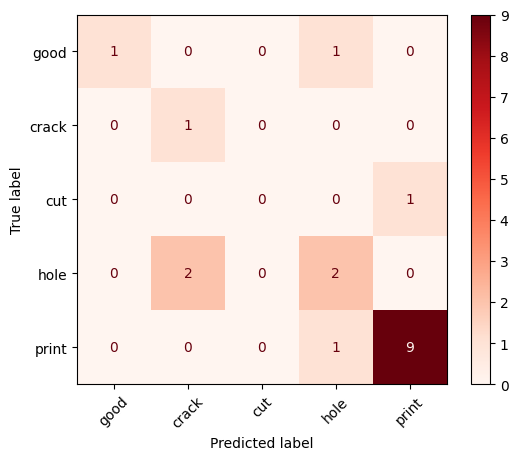

In [15]:
#@title TO DO: Print the confusion matrix using the predictions and ground truth labels

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=defect_spec.class_names)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=defect_spec.class_names)
disp.plot(cmap=plt.cm.Reds)
plt.xticks(rotation=45)
plt.show()


## Observations (TO DO)

What did you observe? Will a different classification spec improve things? If yes, then try it out below.

##**Observations – Confusion Matrix**##

I analyzed the confusion matrix to understand class-level performance. **For example, “good” images were sometimes misclassified as “hole,” “hole” images were often misclassified as “crack,” and “cut” samples as “print.” In contrast, “print” had the strongest performance, being mostly classified correctly.** This highlights that the model struggles with subtle defect differences, a limitation amplified by the small dataset size.

## **Experimentation with Prompts and Augmentation**##

In the first specification, I used the **ViT-B/32** model, and in the second specification, I switched to the **ViT-B/16 model along with shorter and refined prompts.** However, this change did not significantly improve classification accuracy. I also attempted **image augmentation techniques, such as positional shifts and transformations**, though the code is not included here. Despite these efforts, the misclassification patterns largely remained unchanged.
## **Iterative Prompt Adjustment**##

I further examined which images were misclassified and iteratively adjusted the prompts in response. However, this approach also failed to resolve the issue, again due to the **limited number of images per class**, which restricted the model’s ability to generalize effectively.

##**Conclusion**##

From these experiments, I observed that while WinCLIP provides a strong foundation for zero-shot classification, it faces challenges in fine-grained industrial defect detection when datasets are small. **Misclassifications persisted despite prompt engineering and image augmentation.** To achieve robust performance, the approach requires larger datasets, targeted fine-tuning, or complementary methods beyond zero-shot prompting alone.



## [Optional/Bonus] Rerun 1: With a different spec

In [16]:
from spec import DefectClassificationSpec

# New spec with simpler and shorter prompts
defect_spec_v2 = DefectClassificationSpec(
    model_name="ViT-B/16",   # Trying out a different model
    class_names=["good", "crack", "cut", "hole", "print"],
   prompts=[
        ["A photo of a good hazelnut"],
        ["A photo of a hazelnut with a crack"],
        ["A photo of a hazelnut with a cut"],
        ["A photo of a hazelnut with a hole"],
        ["A photo of a hazelnut with a print defect"]
    ]
)


Counts per true label: Counter({'print': 10, 'hole': 4, 'good': 2, 'crack': 1, 'cut': 1})


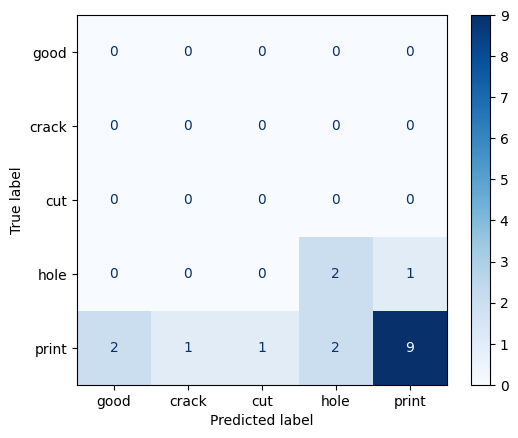

In [17]:
#Confusion matrix for the new spec
y_pred, y_true, file_paths = classify_defects(test_dir, defect_spec_v2, return_paths=True)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=defect_spec_v2.class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=defect_spec_v2.class_names)
disp.plot(cmap="Blues")
plt.show()


In [18]:
#@title TO DO: Commit the changes to the python files to the current feature branch

# Add modified files (spec.py and clip_ac.py) to staging
!git add spec.py clip_ac.py

# Commit changes in the feature/template-code branch
!git commit -m "Implemented defect classification with WinCLIP prompts and observations"

On branch main
Your branch is ahead of 'origin/main' by 3 commits.
  (use "git push" to publish your local commits)

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	__pycache__/
	data/hazelnut_crack_002.png
	data/hazelnut_cut_003.png
	data/hazelnut_good_023.png
	data/hazelnut_good_037.png
	data/hazelnut_hole_005.png
	data/hazelnut_hole_010.png
	data/hazelnut_hole_013.png
	data/hazelnut_hole_016.png
	data/hazelnut_print_003.png
	data/hazelnut_print_004.png
	data/hazelnut_print_005.png
	data/hazelnut_print_006.png
	data/hazelnut_print_007.png
	data/hazelnut_print_009.png
	data/hazelnut_print_011.png
	data/hazelnut_print_012.png
	data/hazelnut_print_013.png
	data/hazelnut_print_016.png

nothing added to commit but untracked files present (use "git add" to track)


In [19]:
#@title TO DO: Switch to the main branch, and merge the feature branch into the main branch

# Switching from feature branch to main branch
!git checkout main

# Merging the feature branch into main
!git merge feature/template-code

Already on 'main'
Your branch is ahead of 'origin/main' by 3 commits.
  (use "git push" to publish your local commits)
Already up to date.


In [20]:
#@title TO DO: Verify git log to see the latest commit
!git log --oneline --graph --decorate -n 5

* 61e5387 (HEAD -> main, feature/template-code) Implemented defect classification with WinCLIP prompts and observations
* c9d8665 (origin/feature/template-code) Update README.md to fix 'References'
* 3a22633 Template code for the assignment.
* d6c1daf (origin/main, origin/HEAD) Basic project structure.


In [21]:
#@title TO DO: Display the changes in the `spec.py` file in the main branch
!git show main:spec.py | head -40

"""
Spec containing the configuration for the defect classification task
"""
from pydantic import BaseModel


class DefectClassificationSpec(BaseModel):
    """
    Configuration for defect classification.

    Attributes:
        class_names: List[str]; The list of class names (normal, defect categories).
        prompts: List[str]; The list of prompts corresponding to the class names.
        model_name (str): Name of the CLIP model variant to use.
    """
    # TODO: Define attributes here with appropriate types and default values if any.
    model_name: str = "ViT-B/32"
    class_names: list[str] = ["good","crack", "cut", "hole", "print"]
    prompts: list[list[str]] = [
    # good
    ["A perfect hazelnut with smooth unblemished shell",
     "A flawless hazelnut with natural brown surface",
     "A pristine nut showing no defects or damage",
     "hazelnut with perfect brown shell surface no holes cracks cuts",
     "brown hazelnut showing flawless natural texture not damaged",
  

# Submission

* Verify that this Colab notebook is owned by you, and in your Google Drive.
* Change the 'Share' settings to 'Anyone with the link' - give read access only.
* Copy the link to the notebook through the 'Share' settings.
* Open a new anonymous browser window, where you are not signed in. Verify that the link you copied opens the notebook, and that all outputs are visible.
* Submit this link through the internship application form.